limited interfernece: 10000 unlimited interference: 32000
limited SM: 6000 unlimited SM: 10000
y shape (4687, 1)
VBS data shape: (4687, 30) (4687, 1) (4687, 1)
Plus 1: 42000
Event yield is: 0.085141905 .
Event yield is: 0.00022501772 .
Event yield is: 0.050693575 .
Number of events: 4930
Class Distribution (Full Dataset): {0: 2276, 1: 2411}
Train Set Class Distribution: {0: 1832, 1: 1917}
Validation Set Class Distribution: {0: 216, 1: 253}
Test Set Class Distribution: {0: 228, 1: 241}
min: -8.001595233508851e-06 max: 8.001595233508851e-06
Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5149 - loss: -4.5123e-06 - val_accuracy: 0.5394 - val_loss: -8.8776e-06
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4952 - loss: -1.2565e-05 - val_accuracy: 0.5394 - val_loss: -1.8632e-05
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5157 - loss: -2.3344e-05 - val_accuracy: 0.5394 - val_loss: -3.3219e-05
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0

/tmp/ipykernel_913/909984388.py:264: RuntimeWarning: invalid value encountered in divide
  chi_squared = np.sum(((observed - expected) / uncertainty) ** 2)


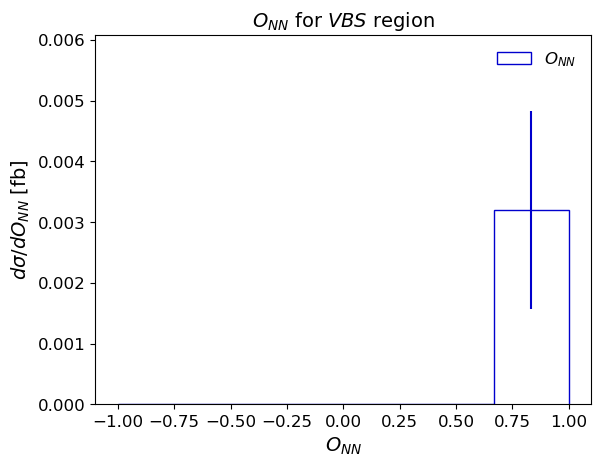

O_NN Fractional Uncertainty: [0.         0.         0.         0.         0.         0.50998133]


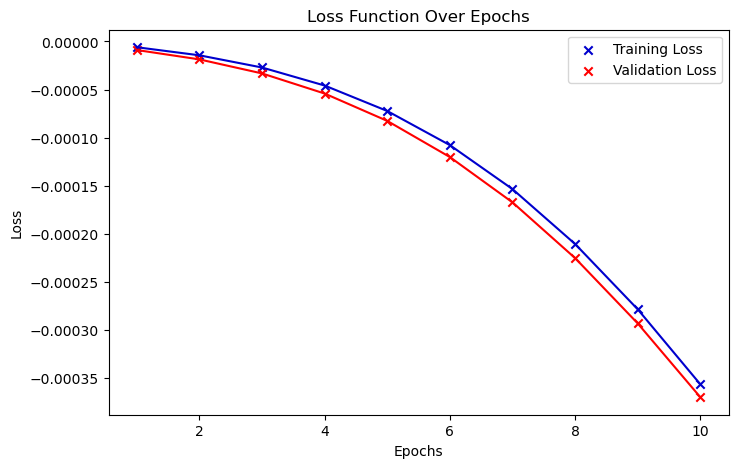

In [164]:
import uproot
import awkward as ak
import vector
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import boost_histogram as bh
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras_tuner
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import pyarrow.feather as feather

m_e = const.electron_mass / 1000
m_mu = 0.105658

def import_raw_data():
    tree_plus_0 = uproot.open('../Delphes/delphes_output_WWjj_e+mu_smeft_cWtil_NP0.root:Delphes')
    plus_events_0 = tree_plus_0.arrays(['Event.Weight', 'Electron_size', 'Electron.Eta', 'Electron.PT',
                           'Electron.Phi', 'Muon_size', 'Muon.PT', 'Muon.Eta', 'Muon.Phi',
                           'Jet_size', 'Jet.PT', 'Jet.Eta', 'Jet.Phi','Jet.Mass','Jet.BTag',])
    
    tree_plus_1 = uproot.open('../Delphes/output_WWjj_e+mu_smeft_cWtil_NP1_tot.root:Delphes')
    plus_events_1 = tree_plus_1.arrays(['Event.Weight', 'Electron_size', 'Electron.Eta', 'Electron.PT',
                           'Electron.Phi', 'Muon_size', 'Muon.PT', 'Muon.Eta', 'Muon.Phi',
                           'Jet_size', 'Jet.PT', 'Jet.Eta', 'Jet.Phi','Jet.Mass','Jet.BTag',])
    
    tree_plus_2 = uproot.open('../Delphes/delphes_output_WWjj_e+mu_smeft_cWtil_NP2.root:Delphes')
    plus_events_2 = tree_plus_2.arrays(['Event.Weight', 'Electron_size', 'Electron.Eta', 'Electron.PT',
                           'Electron.Phi', 'Muon_size', 'Muon.PT', 'Muon.Eta', 'Muon.Phi',
                           'Jet_size', 'Jet.PT', 'Jet.Eta', 'Jet.Phi','Jet.Mass','Jet.BTag',])
    
    limited_tree_plus_0 = uproot.open('../Delphes/delphes_output_WWjj_e+mu_smeft_cWtil_NP0_m_jj=200_tot.root:Delphes')
    limited_plus_events_0 = limited_tree_plus_0.arrays(['Event.Weight', 'Electron_size', 'Electron.Eta', 'Electron.PT',
                           'Electron.Phi', 'Muon_size', 'Muon.PT', 'Muon.Eta', 'Muon.Phi',
                           'Jet_size', 'Jet.PT', 'Jet.Eta', 'Jet.Phi','Jet.Mass','Jet.BTag',])
    
    limited_tree_plus_1 = uproot.open('../Delphes/output_WWjj_e+mu_smeft_cWtil_NP1_m_jj=200_tot.root:Delphes')
    limited_plus_events_1 = limited_tree_plus_1.arrays(['Event.Weight', 'Electron_size', 'Electron.Eta', 'Electron.PT',
                           'Electron.Phi', 'Muon_size', 'Muon.PT', 'Muon.Eta', 'Muon.Phi',
                           'Jet_size', 'Jet.PT', 'Jet.Eta', 'Jet.Phi','Jet.Mass','Jet.BTag',])
    
    limited_tree_plus_2 = uproot.open('../Delphes/delphes_output_WWjj_e+mu_smeft_cWtil_NP2_m_jj=200.root:Delphes')
    limited_plus_events_2 = limited_tree_plus_2.arrays(['Event.Weight', 'Electron_size', 'Electron.Eta', 'Electron.PT',
                           'Electron.Phi', 'Muon_size', 'Muon.PT', 'Muon.Eta', 'Muon.Phi',
                           'Jet_size', 'Jet.PT', 'Jet.Eta', 'Jet.Phi','Jet.Mass','Jet.BTag',])

    total_plus_events_0 = ak.concatenate([plus_events_0, limited_plus_events_0], mergebool=True, highlevel=True)
    total_plus_events_1 = ak.concatenate([plus_events_1, limited_plus_events_1], mergebool=True, highlevel=True)
    total_plus_events_2 = ak.concatenate([plus_events_2, limited_plus_events_2], mergebool=True, highlevel=True)

    print("limited interfernece:", len(limited_plus_events_1),"unlimited interference:", len(plus_events_1))
    print("limited SM:", len(limited_plus_events_0),"unlimited SM:", len(plus_events_0))
    return total_plus_events_0, total_plus_events_1, total_plus_events_2

def import_VBS_data():
    df = feather.read_feather("../VBS_cuts/VBS_data.feather")
    weight_data = df["Weight"].values.reshape(-1, 1)
    y_data = np.array(weight_data)
    y_data = (y_data > 0).astype(int)
    y_data = y_data
    print("y shape", y_data.shape)

    feature_columns = [col for col in df.columns if col not in ["Weight", "Binary_Weight"]]
    x_data = df[feature_columns].values
    print("VBS data shape:", x_data.shape, y_data.shape, weight_data.shape)

    return x_data, y_data, weight_data

def di_invariant_mass_calc(particles):
    diparticle_mass = (particles[:, 0] + particles[:, 1]).mass  # calculates invariant mass for electron-electron or muon-muon pairs
    return diparticle_mass

def cross_invariant_mass_calc(particle_1, particle_2):
    diparticle_mass = (particle_1[:, 0] + particle_2[:, 0]).mass  # calculates invariant mass for electron-muon pairs
    return diparticle_mass

def delta_eta(particles):
    return np.abs(particles[:, 0].eta - particles[:, 1].eta)

def di_transverse_momentum(particle_1, *particle_2):
    if len(particle_2) == 0:
        diparticle_momentum = (particle_1[:, 0] + particle_1[:, 1]).pt
    else:
        diparticle_momentum = (particle_1[:, 0] + particle_2[0][:, 0]).pt
    print(np.max(diparticle_momentum))
    print(np.min(diparticle_momentum))
    return diparticle_momentum

def electron_muon_cuts(events, cross_section, k_factor):
    cut_flow_counts = {
        'Initial': len(events),
        'Single Lepton Selection': 0,
        'Pt and Eta Lepton Cuts': 0,
        'Highest Pt Lepton': 0,
        'Invariant Mass Lepton Cuts': 0,
        'Jet Size': 0,
        'Pt and Eta Jet Cuts': 0,
        'Delta Eta Jet Cut': 0,
        'Invariant Mass Jet Cut': 0
        }
    weights = events['Event.Weight']

    single_electron_muon_mask = (events['Electron_size'] == 1) & (events['Muon_size'] == 1)
    unfiltered_events = events[single_electron_muon_mask]
    cut_flow_counts['Single Lepton Selection'] = len(unfiltered_events)

    electron_pt = unfiltered_events['Electron.PT']
    electron_eta = unfiltered_events['Electron.Eta']
    muon_pt = unfiltered_events['Muon.PT']
    muon_eta = unfiltered_events['Muon.Eta']

    electron_pt_mask = electron_pt > 20
    electron_eta_mask = np.abs(electron_eta) < 2.47
    exclusion_mask = (np.abs(electron_eta) < 1.37) | (np.abs(electron_eta) > 1.52)
    total_electron_mask = electron_pt_mask & electron_eta_mask & exclusion_mask
    muon_pt_mask = muon_pt > 20
    muon_eta_mask = np.abs(muon_eta) < 2.5
    total_muon_mask = muon_pt_mask & muon_eta_mask

    filtered_mask = (ak.sum(total_electron_mask, axis=1) == 1) & (ak.sum(total_muon_mask, axis=1) == 1)
 
    cut_flow_counts['Pt and Eta Lepton Cuts'] = len(unfiltered_events[filtered_mask])

    highest_pt_lepton_mask = (electron_pt >= muon_pt)
    highest_pt_cut = 27
    highest_pt_mask = ((highest_pt_lepton_mask & (electron_pt > highest_pt_cut)) | 
                       (~highest_pt_lepton_mask & (muon_pt > highest_pt_cut)))
    
    total_electron_mask = total_electron_mask & highest_pt_mask
    filtered_mask = (ak.sum(total_electron_mask, axis=1) == 1) & (ak.sum(total_muon_mask, axis=1) == 1)
    
    filtered_events = unfiltered_events[filtered_mask]
    filtered_weights = weights[filtered_mask]

    cut_flow_counts['Highest Pt Lepton'] = len(filtered_events)

    filtered_electrons = electron_vector(filtered_events)
    filtered_muons = muon_vector(filtered_events)

    filtered_electron_muon_mass = cross_invariant_mass_calc(filtered_electrons, filtered_muons)
    electron_muon_invariant_mass_mask = (filtered_electron_muon_mass > 40) & (filtered_electron_muon_mass < 400)
    filtered_electron_muon_mass = filtered_electron_muon_mass[electron_muon_invariant_mass_mask]

    filtered_events = filtered_events[electron_muon_invariant_mass_mask]
    filtered_weights = filtered_weights[electron_muon_invariant_mass_mask]
    cut_flow_counts['Invariant Mass Lepton Cuts'] = len(filtered_events)

    return filtered_events, filtered_weights, cut_flow_counts

def jet_cuts(filtered_events, events, filtered_weights, k_factor, cut_flow_counts):
    jet_size_mask = filtered_events['Jet_size'] >= 2
    cut_flow_counts['Jet Size'] = len(filtered_events[jet_size_mask])

    jet_b_tag = filtered_events['Jet.BTag'] == 0
    jet_pt = filtered_events['Jet.PT']
    jet_eta = filtered_events['Jet.Eta']

    forward_jet_mask = ((np.abs(filtered_events['Jet.Eta']) > 2.5) & (np.abs(filtered_events['Jet.Eta']) < 4.5) & (filtered_events['Jet.PT'] > 30)) & jet_b_tag
    central_jet_mask = ((np.abs(filtered_events['Jet.Eta']) < 2.5) & (filtered_events['Jet.PT'] > 20)) & jet_b_tag
    central_jet_region_mask = (abs(filtered_events['Jet.Eta']) < 2.5)

    total_forward_central_mask = forward_jet_mask | central_jet_mask
    filtered_central_jet_mask = (ak.sum(central_jet_region_mask, axis=1) >= 2) & ak.all(total_forward_central_mask, axis=1)
    cut_flow_counts['Pt and Eta Jet Cuts'] = len(filtered_events[filtered_central_jet_mask])

    jet_eta = filtered_events['Jet.Eta'][filtered_central_jet_mask]
    jet_pt = filtered_events['Jet.PT'][filtered_central_jet_mask]
    jet_phi = filtered_events['Jet.Phi'][filtered_central_jet_mask]
    jet_mass = filtered_events['Jet.Mass'][filtered_central_jet_mask]

    jet_pt_masked = jet_pt.mask[jet_eta < 2.5]
    jet_eta_masked = jet_eta.mask[jet_eta < 2.5]
    jet_phi_masked = jet_phi.mask[jet_eta < 2.5]
    jet_mass_masked = jet_mass.mask[jet_eta < 2.5]
    jet_pt_masked = ak.drop_none(jet_pt_masked, highlevel=True)
    jet_eta_masked = ak.drop_none(jet_eta_masked, highlevel=True)
    jet_phi_masked = ak.drop_none(jet_phi_masked, highlevel=True)
    jet_mass_masked = ak.drop_none(jet_mass_masked, highlevel=True)

    jets_central = vector.zip({
        'pt':jet_pt_masked,
        'eta':jet_eta_masked,
        'phi':jet_phi_masked,
        'mass':jet_mass_masked
    })

    central_jet_mass = di_invariant_mass_calc(jets_central)
    central_jet_eta = delta_eta(jets_central)

    jets_central_mass_cut_mask = (central_jet_mass < 160)
    cut_flow_counts['Invariant Mass Jet Cut'] = len(filtered_events[jets_central_mass_cut_mask])
    jets_central_delta_eta_cut_mask = (central_jet_eta < 1.5)
    cut_flow_counts['Delta Eta Jet Cut'] = len(filtered_events[jets_central_delta_eta_cut_mask])

    central_jet_cut_mask = jets_central_mass_cut_mask & jets_central_delta_eta_cut_mask

    filtered_events = filtered_events[filtered_central_jet_mask]
    filtered_events = filtered_events[central_jet_cut_mask]
    filtered_weights = filtered_weights[filtered_central_jet_mask]
    filtered_weights = filtered_weights[central_jet_cut_mask]

    weight_normalisation = NP_normalisation(events, k_factor)
    filtered_weights = (weight_normalisation * np.ones_like(filtered_weights)) * filtered_weights

    print("Event yield is:", np.sum(filtered_weights) ,".")

    return filtered_events, filtered_weights

def electron_vector(filtered_events):
    electrons = vector.zip({
        'pt': filtered_events['Electron.PT'],
        'eta': filtered_events['Electron.Eta'],
        'phi': filtered_events['Electron.Phi'],
        'mass': m_e})
    electrons = ak.drop_none(electrons, highlevel=True)
    
    return electrons

def muon_vector(filtered_events):
    muons = vector.zip({
        'pt': filtered_events['Muon.PT'],
        'eta': filtered_events['Muon.Eta'],
        'phi': filtered_events['Muon.Phi'],
        'mass': m_mu})
    muons = ak.drop_none(muons, highlevel=True)
    
    return muons

def lepton_vector(filtered_events):
    electrons = electron_vector(filtered_events)
    muons = muon_vector(filtered_events)

    combined_particles = ak.concatenate([muons, electrons], axis=1, highlevel=True)
    combined_ordered_particles = combined_particles[ak.argsort(combined_particles.pt, ascending=False)]
    
    return combined_ordered_particles

def jet_vector(filtered_events):
    jets = vector.zip({
        'pt': filtered_events['Jet.PT'],
        'eta': filtered_events['Jet.Eta'],
        'phi': filtered_events['Jet.Phi'],
        'mass': filtered_events['Jet.Mass']})
    jets = ak.drop_none(jets, highlevel=True)
    jets = jets[ak.argsort(jets.pt, ascending=False)]

    return jets

def NP_normalisation(events, k_factor):
    luminosity = 139 # fb^-1
    normalised_weight = (1 / len(events)) * luminosity * k_factor

    return normalised_weight

def bin_widths(histogram):
    bin_width = histogram[1:] - histogram[:-1]
    return bin_width

def chi_squared(observed, expected, uncertainty):
    chi_squared = np.sum(((observed - expected) / uncertainty) ** 2)
    return chi_squared

def ak_to_numpy_array(root_observable):
    nested_counts = ak.num(root_observable)
    max_len = ak.max(nested_counts)

    root_observable = ak.pad_none(root_observable, target=max_len, axis=1)
    root_observable = ak.fill_none(root_observable, 0)
    root_observable = ak.to_numpy(root_observable)

    return root_observable

def object_selector(filtered_events, filtered_weights):
    print("Number of events:", len(filtered_weights))
    jet_eta = filtered_events['Jet.Eta']
    jet_phi = filtered_events['Jet.Phi']
    electron_eta = filtered_events['Electron.Eta']
    electron_phi = filtered_events['Electron.Phi']
    muon_eta = filtered_events['Muon.Eta']
    muon_phi = filtered_events['Muon.Phi']

    jet_eta = ak_to_numpy_array(jet_eta)
    jet_phi = ak_to_numpy_array(jet_phi)
    electron_eta = ak_to_numpy_array(electron_eta)
    electron_phi = ak_to_numpy_array(electron_phi)
    muon_eta = ak_to_numpy_array(muon_eta)
    muon_phi = ak_to_numpy_array(muon_phi)
    weight_data = ak_to_numpy_array(filtered_weights)

    x_data = np.concatenate([jet_eta, jet_phi, electron_eta, electron_phi, muon_eta, muon_phi], axis=-1)

    y_data = np.array(filtered_weights)
    y_data = (y_data > 0).astype(int)
    y_data = y_data

    return x_data, y_data, weight_data

def build_ML_model(hp, *args):
    input_shape = args[0]

    model = keras.Sequential()
    model.add(keras.Input(shape=input_shape))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=hp.Int('units', min_value=16, max_value=512, step=1), activation='relu'))
    model.add(keras.layers.Dropout(rate=hp.Float('dropout', 0.1, 0.3, step=0.01)))
    model.add(keras.layers.Dense(2, activation='softmax'))

    loss_fn = keras.losses.BinaryCrossentropy()
    model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

    return model

def ML_training(x_data, y_data, weight_data):
    x_train, x_test, y_train, y_test, train_weights, test_weights = train_test_split(x_data, y_data, weight_data, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    model = keras_tuner.RandomSearch(
        lambda hp: build_ML_model(hp, x_train.shape[1:]),
        objective='val_loss',
        max_trials=5,
        directory='keras_tuner_2',
        project_name='keras_training'
    )
    
    model.search(x_train, y_train, sample_weight=train_weights, epochs=10, validation_data=(x_test, y_test, test_weights))
    best_model = model.get_best_models(num_models=1)[0]
    best_model.evaluate(x_test, y_test, sample_weight=test_weights, verbose=2)
    
    best_hp = model.get_best_hyperparameters(num_trials=1)[0]
    print("Best hyperparameters:", best_hp.values)

    best_model.save("tensor_flow_2.keras")
    final_results = best_model.predict(x_data)
    probability_model = tf.keras.Sequential([best_model, tf.keras.layers.softmax()])
    final_results = probability_model.predict(x_data)

    #plot_loss_function(model)

    return final_results 

def VBS_JJ_ML_observable_training(x_data, y_data, weight_data):
    epoch_number = 10
    x_data = StandardScaler().fit_transform(x_data)
    
    unique, counts = np.unique(y_data, return_counts=True)
    print("Class Distribution (Full Dataset):", dict(zip(unique, counts)))

    x_train, x_test, y_train, y_test, train_weights, test_weights = train_test_split(x_data, y_data, weight_data, test_size=0.2, random_state=42)
    x_validate, x_test, y_validate, y_test, validate_weights, test_weights = train_test_split(x_test, y_test, test_weights, test_size=0.5, random_state=42)

    unique_train, counts_train = np.unique(y_train, return_counts=True)
    unique_validate, counts_validate = np.unique(y_validate, return_counts=True)
    unique_test, counts_test = np.unique(y_test, return_counts=True)

    print("Train Set Class Distribution:", dict(zip(unique_train, counts_train)))
    print("Validation Set Class Distribution:", dict(zip(unique_validate, counts_validate)))
    print("Test Set Class Distribution:", dict(zip(unique_test, counts_test)))
    
    print("min:", np.min(weight_data), "max:", np.max(weight_data))

    model = tf.keras.models.Sequential([ 
        tf.keras.Input(shape=(x_train.shape[1],)),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(2) 
    ])

    predictions = model(x_train[:1]).numpy() 
    tf.nn.softmax(predictions).numpy() #doing this will produce incorrect probabilites?

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) #and with =False is bad
    loss_fn(y_train[:1], predictions).numpy()

    model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy']) 
    history = model.fit(x_train, y_train, sample_weight=train_weights, epochs=epoch_number, validation_data=(x_validate, y_validate, validate_weights))
    model.evaluate(x_test, y_test, sample_weight=test_weights, verbose=2)
    model.save("tensor_flow_1.keras")

    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    probability_model = tf.keras.Sequential([model,tf.keras.layers.Softmax()]) #and this

    final_results = probability_model.predict(x_data)
    
    for i in final_results:
        print(i)

    return final_results, training_loss, validation_loss, epoch_number

def load_ML_model(x_data):
    loaded_model = tf.keras.models.load_model("tensor_flow_2.keras")
    final_results = loaded_model.predict(x_data)

    return final_results 

def plot_ML_observable(ML_results, weight_data):
    scale_factor = 1
    ML_observable = ML_results[:, 1] - ML_results[:, 0]

    bin_number = 6
    range_limit = (-1, 1)

    histogram_0 = bh.Histogram(bh.axis.Regular(bin_number, *range_limit, underflow=False, overflow=False))
    print("ML + Weight shape", ML_observable.shape, weight_data.shape)
    histogram_0.fill(ML_observable, weight=weight_data)
    
    bin_widths = histogram_0.axes[0].widths
    differential_cross_section_0 = histogram_0.view() / bin_widths
    
    hist_0_squared = bh.Histogram(histogram_0.axes[0])
    hist_0_squared.fill(ML_observable, weight=weight_data**2)

    uncertainty_0 = np.sqrt(hist_0_squared.view()) / bin_widths

    bin_centers = histogram_0.axes[0].centers
    bin_edges = histogram_0.axes[0].edges

    chi_squared_1 = chi_squared(differential_cross_section_0, 0, uncertainty_0)
    print("chi_squared_1 about y=0:", chi_squared_1)

    plt.figure()

    plt.hist(bin_edges[:-1], bins=bin_edges, weights=differential_cross_section_0 /scale_factor, label=r"$O_{NN}$", color='mediumblue', histtype='step')
    plt.errorbar(bin_centers, differential_cross_section_0 / scale_factor, yerr=uncertainty_0 /scale_factor, fmt='None', color='mediumblue')

    plt.title(r'$O_{NN}$ for $VBS$ region', fontsize=14)
    plt.xlabel(r'$O_{NN}$', fontsize=14)
    plt.ylabel(r'$d\sigma/dO_{NN}$ [fb]', fontsize=14)
    y_min, y_max = plt.ylim()
    plt.ylim(y_min, y_max + 0.20 * (y_max - y_min))
    plt.xticks(fontsize=12)  
    plt.yticks(fontsize=12)
    plt.legend(frameon=False, fontsize=12)
    plt.savefig(f"O_NN_2_VBS_jj.png", dpi=1000, bbox_inches="tight")
    plt.show()

    fractional_uncertainty_0 = np.divide(
        uncertainty_0, differential_cross_section_0,
        out=np.zeros_like(uncertainty_0),
        where=differential_cross_section_0 != 0
    )

    print("O_NN Fractional Uncertainty:", fractional_uncertainty_0)

def plot_loss(training_loss, validation_loss, epoch_number):    
    epoch_number = np.arange(1, epoch_number + 1)    
    plt.figure(figsize=(8, 5))
    plt.scatter(epoch_number, training_loss, label='Training Loss', marker='x', color='mediumblue')
    plt.plot(epoch_number, training_loss, linestyle='-', color='mediumblue')
    plt.scatter(epoch_number, validation_loss, label='Validation Loss', marker='x', color='red')
    plt.plot(epoch_number, validation_loss, linestyle='-', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Function Over Epochs')
    plt.legend()
    plt.show()
    
def print_branches(tree):
    keys = tree.keys()
    for key in keys:
        print(key)
    
def __main__():
    plus_events_0, plus_events_1, plus_events_2 = import_raw_data()
    x_data_VBS, y_data_VBS, weight_data_VBS = import_VBS_data()
    print("Plus 1:", len(plus_events_1['Event.Weight']))
    plus_cross_section = 2.486
    minus_cross_section = 1.096
    plus_k_factor = 136 / 73.69
    minus_k_factor = 76 / 39.26

    plus_filtered_events_0, filtered_weights_0, plus_cut_flow_counts_0 = electron_muon_cuts(plus_events_0, plus_cross_section, plus_k_factor)
    plus_filtered_events_1, filtered_weights_1, plus_cut_flow_counts_1 = electron_muon_cuts(plus_events_1, plus_cross_section, plus_k_factor)
    plus_filtered_events_2, filtered_weights_2, plus_cut_flow_counts_2 = electron_muon_cuts(plus_events_2, plus_cross_section, plus_k_factor)
    
    plus_final_filtered_events_0, plus_final_filtered_weights_0 = jet_cuts(plus_filtered_events_0, plus_events_0, filtered_weights_0, plus_k_factor, plus_cut_flow_counts_0)
    plus_final_filtered_events_1, plus_final_filtered_weights_1 = jet_cuts(plus_filtered_events_1, plus_events_1, filtered_weights_1, plus_k_factor, plus_cut_flow_counts_1)
    plus_final_filtered_events_2, plus_final_filtered_weights_2 = jet_cuts(plus_filtered_events_2, plus_events_2, filtered_weights_2, plus_k_factor, plus_cut_flow_counts_2)
    
    x_data_1, y_data_1, weight_data_1 = object_selector(plus_final_filtered_events_1, plus_final_filtered_weights_1)
    ML_results_1, training_loss_1, validation_loss_1, epoch_number = VBS_JJ_ML_observable_training(x_data_VBS, y_data_VBS, weight_data_VBS)
    plot_ML_observable(ML_results_1, weight_data_VBS)
    plot_loss(training_loss_1, validation_loss_1, epoch_number)

if __name__ == '__main__':
    __main__()